In [3]:
import dwave
import dimod
import neal
import os
from dwave.system import DWaveSampler, EmbeddingComposite, LeapHybridCQMSampler
from dimod import BinaryQuadraticModel, ConstrainedQuadraticModel, Binary
from neal import SimulatedAnnealingSampler
os.environ['DWAVE_API_TOKEN'] = 'DEV-02d687c5521a014df6c14e8a3ae5694cb67d5a8f'

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import numpy as np

import sys
sys.path.insert(0, '/Users/juanfrancisco/Desktop/uc/uc-problem-annealing/utils')
from utils import get_index, get_generator_and_day
from plots import plot_schedule

# Problem definition

This notebook gives a computational representation of the Constrained Quadratic Model (CQM) for the Unit Commitment (UC) problem for a plan operator that minimises the sum of total operating expenditure of generation across generation units and a demand shortfall penalty.

**Variables**
- N: number of power plants (n = 1, ..., N)
- T: time periods (t = 1, ..., T)
- i(n,t): composite index of size NT
- x_i: binary vector of size NT indicating the state of power plant (x_00 = 0 -> off, x_00 = 1 -> on)
- C_i: vector representing the cost of operating each power plant n at time t
- D(t): demand for a time period
- E_i: vector representing the efficiency of each power plant n at time t

In [4]:
n_generators = 5
n_hours = 12
size = n_hours * n_generators

C = np.random.randint(1, 11, size= size)     # cost of power plants at different hours
E = np.random.randint(1, 11, size=size)     # efficiency of power plants at different times
D = 10     # demand for a specific time period

# Constrained Quadratic Model

In [18]:
# define a constrained quadratic model instance
cqm = ConstrainedQuadraticModel()

In [19]:
#define the variables
x = {(n, t): Binary('x{}_{}'.format(n, t)) for n in range(n_generators) for t in range(n_hours)}

In [20]:
#define the objective function
for generator in range(n_generators):
    for hour in range(n_hours):
        index = get_index(generator, hour, n_hours)
        cqm.set_objective(x[generator, hour] * C[index])

In [21]:
#define the contraints
sum = 0
for hour in range(n_hours):
    for generator in range(n_generators):
        index = get_index(generator, hour, n_hours)
        sum += E[index] * x[generator, hour]
cqm.add_constraint(sum >= D)

'c89d646'

In [22]:
#sample 
sampler = LeapHybridCQMSampler()
raw_sampleset = sampler.sample_cqm(cqm)
feasible_sampleset = raw_sampleset.filter(lambda d: d.is_feasible)
num_feasible = len(feasible_sampleset)
if num_feasible > 0:
    best_samples = \
        feasible_sampleset.truncate(min(10, num_feasible))
else:
    best_samples = raw_sampleset.truncate(10)

print(" \n" + "=" * 30 + "BEST SAMPLE SET" + "=" * 30)
print(best_samples)

best_sample = best_samples.first.sample

 
==============================BEST SAMPLE SET==============================
  x0_0 x0_1 x0_10 x0_11 x0_2 x0_3 x0_4 x0_5 x0_6 ... x4_9 energy num_oc. ...
0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0 ...  1.0    0.0       1 ...
1  1.0  0.0   0.0   0.0  1.0  1.0  0.0  1.0  1.0 ...  0.0    0.0       1 ...
2  1.0  0.0   1.0   1.0  1.0  1.0  0.0  1.0  0.0 ...  0.0    0.0       1 ...
3  1.0  1.0   1.0   0.0  0.0  0.0  0.0  1.0  1.0 ...  1.0    0.0       1 ...
4  0.0  1.0   0.0   0.0  1.0  1.0  0.0  0.0  1.0 ...  1.0    0.0       1 ...
5  0.0  0.0   0.0   1.0  0.0  0.0  0.0  1.0  1.0 ...  1.0    0.0       1 ...
6  1.0  1.0   1.0   0.0  1.0  0.0  1.0  0.0  1.0 ...  1.0    0.0       1 ...
7  0.0  0.0   0.0   0.0  1.0  0.0  1.0  0.0  1.0 ...  1.0    0.0       1 ...
8  0.0  0.0   1.0   0.0  0.0  0.0  0.0  1.0  1.0 ...  0.0    0.0       1 ...
9  0.0  1.0   0.0   1.0  1.0  1.0  1.0  0.0  0.0 ...  1.0    0.0       1 ...
['INTEGER', 10 rows, 10 samples, 60 variables]


In [26]:
#filtered_dict = {k: v for k, v in best_sample.items() if 'x' in str(k)}
filtered_keys = [key for key, value in best_sample.items() if value == 1]
completed_list = [item + '0' if len(item) == 2 else item for item in filtered_keys]
new_list = [(int(item.split('_')[0][1:]), int(item.split('_')[1])) for item in completed_list]

# Plot results

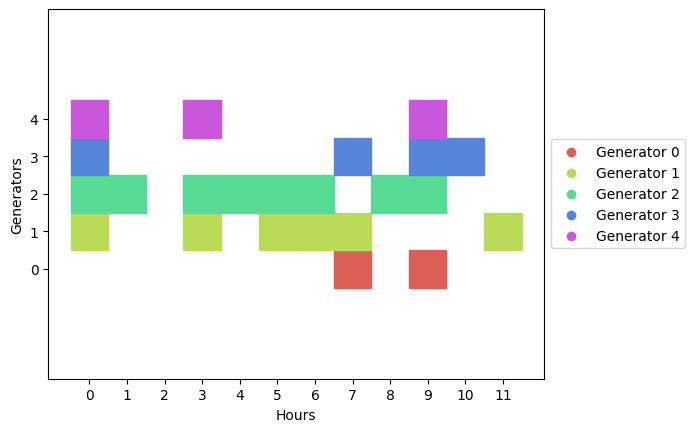

In [27]:
plot_schedule(new_list, n_hours, n_generators, save_image=False, image_path=None)